# Project 3: Battery Equivalent Circuit Model Design
>**Date Created**: 19 February 2024<br>
>**Course**: AEM566 - Optimal Estimation<br>
>**Author**: Benjamin Lucke<br>

In [35]:
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid, simpson

### 1. Load the battery data for the pulse discharge tests in the accompanying CSV file

In [169]:
data = pd.read_csv('data/pulse_discharge_test_data.csv')

# rename columns to make easier to reference and convert times to datetime for convenience
columnMapper = dict(zip(data.columns.values,['t', 'v', 'i'],)) 
data = data.rename(columns=columnMapper)
data['t'] = pd.to_datetime(data['t'],format="%H:%M:%S")

### 2. Numerically integrate the current to obtain the SOC for the entire data set

In [37]:
soc_full = simpson(data['i'], dx = 10)

### 3. Partition the data into each rest period using the current measurement as the trigger

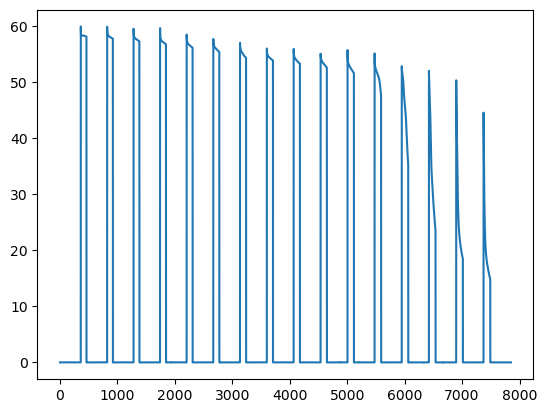

In [133]:
plt.plot(data['i'])

In [260]:
data['i_diff'] = data.loc[:,'i'].diff()
delta_indices = data[(data['i_diff']) > .1].index.tolist()
pairs = list()
for k, index in enumerate(delta_indices):
    if k == len(delta_indices)-1:
        pair = index, data.index[-1]
    else:
        pair = index, delta_indices[k+1]
    pairs.append(pair)
    